In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bert_score import score
from rouge_score import rouge_scorer
from transformers import AutoTokenizer, pipeline
from typing import List
import re
import language_tool_python

C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preprocessing

In [2]:
original_articles = pd.read_csv('original_articles.csv', delimiter=';')
generated_articles = pd.read_csv('generated_articles.csv', delimiter=';')
#llm_as_judge_scores = pd.read_csv('llm_as_judge_scores.csv')

ASL (Average Sentence Length): More words per sentence = more complex.
ASW (Average Syllables per Word): More syllables per word = more complex.
Formula:
206.935−(1.672×ASL)−(62.18×ASW)

coeficients from: Adaptation of Classic Readability Metrics to Czech? Klára Bendová and Silvie Cinková

In [3]:
def count_syllables(word):
    return len(re.findall(r'[aeiouyáéíóúýäô]', word, re.I))

def readability_score(text):
    words = text.split()
    sentences = re.split(r'[.!?]', text)
    syllables = sum(count_syllables(word) for word in words)

    ASL = len(words) / max(1, len(sentences))
    ASW = syllables / max(1, len(words))

    score = 206.935 - (1.672 * ASL) - (62.18 * ASW)
    return score

Lexical diversity

In [4]:
def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words)

def hapax_legomena(text):
    words = text.split()
    word_counts = Counter(words)
    hapax = [word for word, count in word_counts.items() if count == 1]
    return len(hapax) / len(words)

Grammar check

In [5]:
tool = language_tool_python.LanguageTool('sk')

def grammar_errors(text):
    matches = tool.check(text)
    return len(matches)

# Calculate bert, rouge1, rouge2, rougeL and all other scores for each article and save each value in dictionary for further use.

In [6]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
sections = ['Headline', 'Perex', 'Article']
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Dictionary for scores for each article
all_scores = {section: {'bert': [], 'rouge1': [], 'rouge2': [], 'rougeL': [], 
                        #'llm_as_judge': [],
                        'token_length_ratio': [], 'human_readability': [],
                       'ai_readability': [], 'readability_ratio': [], 'human_lexical_diversity': [], 'ai_lexical_diversity': [],
                       'lexical_diversity_ratio': [],'human_grammar_errors': [], 'ai_grammar_errors': [], 'grammar_error_ratio': []}
              for section in sections}
# Calculate and save the scores
for section in sections:
    references = original_articles[section].dropna().tolist()
    hypotheses = generated_articles[section].dropna().tolist()

    # Compute BERTScore
    P, R, F1 = score(hypotheses, references, lang="en", rescale_with_baseline=False)
    all_scores[section]['bert'] = F1.tolist()

    # Compute ROUGE scores
    rouge_scores = [scorer.score(h, r) for h, r in zip(hypotheses, references)]
    all_scores[section]['rouge1'] = [r['rouge1'].fmeasure for r in rouge_scores]
    all_scores[section]['rouge2'] = [r['rouge2'].fmeasure for r in rouge_scores]
    all_scores[section]['rougeL'] = [r['rougeL'].fmeasure for r in rouge_scores]

    # Compute token-length ratio reference vs hypotheses
    token_lengths_hypothesis = [len(tokenizer.tokenize(h)) for h in hypotheses]
    token_lengths_reference = [len(tokenizer.tokenize(r)) for r in references]
    token_length_ratios = [
        h_len / r_len if r_len > 0 else 0
        for h_len, r_len in zip(token_lengths_hypothesis, token_lengths_reference)
    ]
    all_scores[section]['token_length_ratio'] = token_length_ratios
    print("Similiarities done!")
    
    # Compute Slovak readability score
    srs_hypothesis = [readability_score(h) for h in hypotheses]
    srs_reference = [readability_score(r) for r in references]
    all_scores[section]['ai_readability'] = [h for h in srs_hypothesis]
    all_scores[section]['human_readability'] = [r for r in srs_reference]
    all_scores[section]['readability_ratio'] = [srs_h / srs_r if srs_r > 0 else 0
                                                for srs_h, srs_r in zip(srs_hypothesis, srs_reference)]
    print("Readability done!")

    # Compute lexical complexity
    ld_hypothesis = [lexical_diversity(h) for h in hypotheses]
    ld_reference = [lexical_diversity(r) for r in references]
    all_scores[section]['ai_lexical_diversity'] = [h for h in ld_hypothesis]
    all_scores[section]['human_lexical_diversity'] = [r for r in ld_reference]
    all_scores[section]['lexical_diversity_ratio'] = [ld_h / ld_r if ld_r > 0 else 0
                                                for ld_h, ld_r in zip(ld_hypothesis, ld_reference)]
    print("Lexical diversity done!")

    # Compute grammar errors
    grammar_hypothesis = [grammar_errors(h) for h in hypotheses]
    grammar_reference = [grammar_errors(r) for r in references]
    all_scores[section]['ai_grammar_errors'] = [h for h in grammar_hypothesis]
    all_scores[section]['human_grammar_errors'] = [r for r in grammar_reference]
    all_scores[section]['grammar_errors_ratio'] = [grammar_h / grammar_r if grammar_r != 0 else float('inf')
                                                for grammar_h, grammar_r in zip(grammar_hypothesis, grammar_reference)]
    print("Grammar done!")
    

#all_scores['Headline']['llm_as_judge'] = llm_as_judge_scores['Headline'].tolist()
#all_scores['Perex']['llm_as_judge'] = llm_as_judge_scores['Perex'].tolist()
#all_scores['Article']['llm_as_judge'] = llm_as_judge_scores['Article'].tolist()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Similiarities done!
Readability done!
Lexical diversity done!
Grammar done!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Similiarities done!
Readability done!
Lexical diversity done!
Grammar done!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (752 > 512). Running this sequence through the model will result in indexing errors


Similiarities done!
Readability done!
Lexical diversity done!
Grammar done!


# Mean scores of text similiarity for sections

In [7]:
def create_similarity_score_df():
    metrics = {
        'Mean BERTScore': 'bert',
        'Mean ROUGE-1': 'rouge1',
        'Mean ROUGE-2': 'rouge2',
        'Mean ROUGE-L': 'rougeL',
        #'Mean LLM as judge': 'llm_as_judge',
        'Mean token length ratio': 'token_length_ratio'
    }
    
    # Create DataFrame dynamically
    results = pd.DataFrame({
        'Section': sections,
        **{metric_name: [np.mean(all_scores[section][key]) for section in sections]
           for metric_name, key in metrics.items()}
    })
    
    return results

In [8]:
results_df = pd.DataFrame(create_similarity_score_df())
results_df

,Section,Mean BERTScore,Mean ROUGE-1,Mean ROUGE-2,Mean ROUGE-L,Mean token length ratio
0,Headline,0.808457,0.149508,0.039729,0.130069,1.231773
1,Perex,0.812276,0.168795,0.041143,0.129463,1.366752
2,Article,0.846398,0.389908,0.143357,0.189126,1.368589


# Tables per section for other metrics

## Metrics explanation

| **Category**           | **Metric**                          | **Score Range**                |
| ---------------------- | ----------------------------------- | ------------------------------ |
| **Readability**         | Flesh-Kincaid Readability Score (Czech coefficients) | 0–100 (higher = easier to read) |
| **Lexical Diversity**   | Lexical Diversity (`len(set(words)) / len(words)`) | 0–1 (higher = richer vocabulary) |
| **Grammar & Style**     | Grammar Error Count (LanguageTool)  | 0+ (lower = better)           |


## Flesch-kincaid readability score grades
    
| Score            | School Level      | Reading Level       |
|-----------------|------------------|---------------------|
| 90 - 100        | 5th grade        | Very easy          |
| 80 - 90         | 6th grade        | Easy               |
| 70 - 80         | 7th grade        | Fairly easy        |
| 60 - 70         | 8th & 9th grade  | Plain English      |
| 50 - 60         | 10th to 12th grade | Fairly difficult  |
| 30 - 50         | College          | Difficult          |
| 0 - 30          | College graduate | Very difficult     |

In [9]:
def create_and_print_other_metrics():
    metrics = ['Readability', 'Lexical diversity', 'Grammatical errors']
    score_keys = ['readability', 'lexical_diversity', 'grammar_errors']
    
    tables = []
    
    for section in sections:
        results_section = {'Metric': metrics, 'Human score': [], 'AI score': [], 'AI/Human ratio': []}
        
        for key in score_keys:
            results_section['Human score'].append(np.mean(all_scores[section][f'human_{key}']))
            results_section['AI score'].append(np.mean(all_scores[section][f'ai_{key}']))
            results_section['AI/Human ratio'].append(np.mean(all_scores[section][f'{key}_ratio']))

        tables.append(results_section)

    tables_section = ['Headline', 'Perex', 'Article']
    for i in range(len(tables_section)):
        table_df = pd.DataFrame(tables[i])
        table_df.insert(0, "Table" ,tables_section[i])
        display(table_df)

In [10]:
create_and_print_other_metrics()

,Table,Metric,Human score,AI score,AI/Human ratio
0,Headline,Readability,41.806687,36.252669,1.029165
1,Headline,Lexical diversity,0.986227,0.981969,0.996860
2,Headline,Grammatical errors,0.135135,0.662162,inf


,Table,Metric,Human score,AI score,AI/Human ratio
0,Perex,Readability,46.814935,68.950188,2.193757
1,Perex,Lexical diversity,0.959535,0.970033,1.014649
2,Perex,Grammatical errors,0.400901,0.225225,inf


,Table,Metric,Human score,AI score,AI/Human ratio
0,Article,Readability,45.006163,31.498649,0.738509
1,Article,Lexical diversity,0.701021,0.720724,1.044242
2,Article,Grammatical errors,5.639640,1.824324,inf


# Calculate tag accuracy
This metric does not completely reflect the reality of correctly generated tags. For example, generated tags are missing spaces between words as well as diacritic. You can also see that sometimes it generates a synonym tags compared to the original or adds additional word into the tag. In these scenarios the tags have the same meaning, but will be evaluated as incorrect.

In [40]:
valid_rows = original_articles["Tags"].notna() & (original_articles["Tags"] != "N/A")

# Now, filter both references (original_articles) and hypotheses (generated_articles) based on valid rows
references = original_articles["Tags"][valid_rows]
hypotheses = generated_articles["Tags"][valid_rows]

correct_count = 0
total_count = 0

for ref, hyp in zip(references, hypotheses):
    # Transform references to lowercase and split by comma
    ref_tags = {tag.strip().lower() for tag in ref.split(',')}
    # Split hypotheses by space and convert to set
    hyp_tags = {hyp}

    print(f"ref: {ref_tags}\nhyp: {hyp_tags}")

    # For each tag in the hypothesis, check if it exists in the references
    for tag in hyp_tags:
        if tag in ref_tags:
            correct_count += 1
        total_count += 1

# Calculate the tag accuracy
tag_accuracy = correct_count / total_count if total_count > 0 else 0
print(f"\nTag accuracy metric: {tag_accuracy}")

ref: {'#infraštruktúra', '#stavebná produkcia', '#stavebníctvo', '#štatistický úrad'}
hyp: {'#stavebná produkcia'}
ref: {'#pohonné látky', '#benzín', '#štatistický úrad'}
hyp: {'#priemerné ceny pohonných látok'}
ref: {'#ceny potravín', '#potraviny'}
hyp: {'#ceny potravín na slovensku'}
ref: {'#ceny potravín', '#potraviny', '#konsolidácia', '#dph'}
hyp: {'#inflácia na slovensku'}
ref: {'#platy', '#inflácia'}
hyp: {'#rást miezd na slovensku'}
ref: {'#výstavba', '#nájomné bývanie', '#výstavba bytov', '#byty'}
hyp: {'#výstavba bytov'}
ref: {'#inflácia na slovensku', '#ceny potravín', '#zdražovanie'}
hyp: {'#priemerná mesačná mzda'}
ref: {'#platy', '#inflácia'}
hyp: {'#inflácia'}
ref: {'#chudoba', '#hranica chudoby', '#mzda'}
hyp: {'#chudoba na slovensku'}
ref: {'#chudoba'}
hyp: {'#chudoba na slovensku'}
ref: {'#spotreba', '#káva', '#nápoj'}
hyp: {'#spotreba kávy na slovensku'}
ref: {'#zamestnanosť', '#nezamestnanosť'}
hyp: {'#zamestnanosť slovensko'}
ref: {'#platy', '#priemerná mzda'}
hyp:

In [50]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

correct_count = 0
total_count = 0
threshold = 0.6 # Tune based on performance

for ref, hyp in zip(references, hypotheses):
    ref_tags = [tag.strip().lower() for tag in ref.split(',')]
    hyp_tag = hyp.strip().lower()

    # Compute embeddings
    embeddings = model.encode(ref_tags + [hyp_tag], convert_to_tensor=True)
    ref_embeds = embeddings[:-1]
    hyp_embed = embeddings[-1]

    # Compute similarities
    similarities = util.cos_sim(hyp_embed, ref_embeds)[0]

    # If any similarity exceeds threshold, count as correct
    if any(sim > threshold for sim in similarities):
        correct_count += 1
    total_count += 1

tag_accuracy = correct_count / total_count if total_count > 0 else 0
print(f"\nSemantic tag accuracy: {tag_accuracy}")


Semantic tag accuracy: 0.6575342465753424


In [47]:
import random
from sentence_transformers import SentenceTransformer, util

sampled = list(zip(references.tolist(), hypotheses.tolist()))
sampled_pairs = random.sample(sampled, 30)

model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

labeled_pairs = []

for ref, hyp in sampled_pairs:
    ref_tags = [tag.strip().lower() for tag in ref.split(',')]
    hyp_tag = hyp.strip().lower()

    embeddings = model.encode(ref_tags + [hyp_tag], convert_to_tensor=True)
    ref_embeds = embeddings[:-1]
    hyp_embed = embeddings[-1]

    similarities = util.cos_sim(hyp_embed, ref_embeds)[0]

    # Find the max similarity to any reference tag
    max_sim = float(similarities.max())
    labeled_pairs.append((ref_tags, hyp_tag, max_sim))
    
for i, (ref_tags, hyp_tag, sim) in enumerate(labeled_pairs):
    print(f"{i+1}. REF: {ref_tags} | HYP: {hyp_tag} | SIMILARITY: {sim:.3f}")
    label = input("Do they match in meaning? (y/n): ")
    labeled_pairs[i] = (ref_tags, hyp_tag, sim, label.lower() == 'y')


1. REF: ['#benzín', '#ceny pohonných hmôt', '#slovensko', '#štatistický úrad sr'] | HYP: #priemerné ceny pohonných látok | SIMILARITY: 0.820


Do they match in meaning? (y/n):  y


2. REF: ['#turizmus', '#štatistický úrad sr', '#slovensko', '#cestovný ruch', '#tržby'] | HYP: #turizmus na slovensku | SIMILARITY: 0.872


Do they match in meaning? (y/n):  y


3. REF: ['#platy'] | HYP: #maloobchod | SIMILARITY: 0.577


Do they match in meaning? (y/n):  n


4. REF: ['#priemysel', '#slovensko', '#štatistický úrad sr'] | HYP: #priemyselná produkcia | SIMILARITY: 0.688


Do they match in meaning? (y/n):  y


5. REF: ['#ekonomika', '#slovensko'] | HYP: #hrubý domáci produkt | SIMILARITY: 0.487


Do they match in meaning? (y/n):  n


6. REF: ['#zahraničný obchod', '#automobilový priemysel', '#slovensko', '#štatistický úrad sr'] | HYP: #zahraničný obchod slovenska | SIMILARITY: 0.721


Do they match in meaning? (y/n):  y


7. REF: ['#benzín', '#nafta', '#slovensko', '#štatistický úrad sr'] | HYP: #priemerné ceny pohonných látok | SIMILARITY: 0.530


Do they match in meaning? (y/n):  n


8. REF: ['#obchod', '#maloobchod', '#štatistický úrad'] | HYP: #maloobchod | SIMILARITY: 1.000


Do they match in meaning? (y/n):  y


9. REF: ['#mzdy', '#slovensko', '#štatistický úrad sr', '#platy'] | HYP: #zamestnanosť v roku 2025 | SIMILARITY: 0.456


Do they match in meaning? (y/n):  n


10. REF: ['#cestovný ruch', '#hotely', '#slovensko', '#štatistický úrad sr'] | HYP: #priemerná dĺžka pobytu | SIMILARITY: 0.363


Do they match in meaning? (y/n):  n


11. REF: ['#priemysel', '#slovensko', '#štatistický úrad sr', '#zdražovanie'] | HYP: #rast cien poľnohospodárskych produktov | SIMILARITY: 0.466


Do they match in meaning? (y/n):  n


12. REF: ['#doprava', '#slovensko', '#štatistický úrad sr'] | HYP: #objem prepraveného tovaru | SIMILARITY: 0.527


Do they match in meaning? (y/n):  n


13. REF: ['#dovolenka', '#chorvátsko', '#cestovné kancelárie'] | HYP: #štatistický úrad sr | SIMILARITY: 0.768


Do they match in meaning? (y/n):  n


14. REF: ['#inflácia', '#potraviny', '#energia'] | HYP: #inflácia na slovensku | SIMILARITY: 0.822


Do they match in meaning? (y/n):  y


15. REF: ['#slovensko', '#štatistický úrad sr', '#poľnohospodárstvo', '#potraviny', '#priemysel'] | HYP: #ceny stavebných prác | SIMILARITY: 0.355


Do they match in meaning? (y/n):  n


16. REF: ['#inflácia', '#slovensko', '#štatistický úrad sr'] | HYP: #inflácia | SIMILARITY: 1.000


Do they match in meaning? (y/n):  y


17. REF: ['#mzdy', '#slovensko', '#štatistický úrad sr', '#platy'] | HYP: #rást nominálnych miezd | SIMILARITY: 0.415


Do they match in meaning? (y/n):  y


18. REF: ['#inflácia', '#ceny', '#rast'] | HYP: #inflácia na slovensku | SIMILARITY: 0.822


Do they match in meaning? (y/n):  y


19. REF: ['#ekonomika', '#slovensko', '#štatistický úrad sr'] | HYP: #ekonomický sentiment | SIMILARITY: 0.847


Do they match in meaning? (y/n):  y


20. REF: ['#slovensko', '#rast', '#hdp'] | HYP: #hrubý domáci produkt | SIMILARITY: 0.495


Do they match in meaning? (y/n):  y


21. REF: ['#rozpočet', '#deficit'] | HYP: #deficit verejných financií | SIMILARITY: 0.753


Do they match in meaning? (y/n):  y


22. REF: ['#hdp', '#štatistický úrad', '#slovenská ekonomika'] | HYP: #hrubý domáci produkt | SIMILARITY: 0.455


Do they match in meaning? (y/n):  y


23. REF: ['#platy', '#štatistický úrad', '#priemerná mzda', '#mzdy'] | HYP: #zamestnanosť #mzdy #ekonomický rast #slovensko | SIMILARITY: 0.440


Do they match in meaning? (y/n):  y


24. REF: ['#stavebníctvo', '#slovensko', '#štatistický úrad sr'] | HYP: #pokles stavebnej produkcie | SIMILARITY: 0.444


Do they match in meaning? (y/n):  n


25. REF: ['#slovensko', '#štatistický úrad sr', '#sťahovanie', '#migrácia'] | HYP: #počet živých narodení | SIMILARITY: 0.437


Do they match in meaning? (y/n):  n


26. REF: ['#chudoba', '#slovensko', '#štatistický úrad sr'] | HYP: #chudoba na slovensku | SIMILARITY: 0.845


Do they match in meaning? (y/n):  y


27. REF: ['#benzín', '#nafta', '#ceny pohonných hmôt', '#slovensko'] | HYP: #ceny pohonných látok | SIMILARITY: 0.939


Do they match in meaning? (y/n):  y


28. REF: ['#ceny pohonných hmôt', '#slovensko', '#štatistický úrad sr'] | HYP: #priemerné ceny pohonných látok | SIMILARITY: 0.820


Do they match in meaning? (y/n):  y


29. REF: ['#obchodná vojna', '#clo', '#štatistický úrad sr'] | HYP: #rast nových objednávok | SIMILARITY: 0.481


Do they match in meaning? (y/n):  n


30. REF: ['#potraviny', '#inflácia'] | HYP: #inflácia | SIMILARITY: 1.000


Do they match in meaning? (y/n):  y


In [48]:
thresholds = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85]
for threshold in thresholds:
    tp = sum(1 for _, _, sim, label in labeled_pairs if sim >= threshold and label)
    fp = sum(1 for _, _, sim, label in labeled_pairs if sim >= threshold and not label)
    fn = sum(1 for _, _, sim, label in labeled_pairs if sim < threshold and label)

    precision = tp / (tp + fp) if tp + fp else 0
    recall = tp / (tp + fn) if tp + fn else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall else 0

    print(f"Threshold {threshold:.2f} — Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

Threshold 0.50 — Precision: 0.78, Recall: 0.78, F1: 0.78
Threshold 0.60 — Precision: 0.93, Recall: 0.78, F1: 0.85
Threshold 0.70 — Precision: 0.93, Recall: 0.72, F1: 0.81
Threshold 0.75 — Precision: 0.92, Recall: 0.67, F1: 0.77
Threshold 0.80 — Precision: 1.00, Recall: 0.61, F1: 0.76
Threshold 0.85 — Precision: 1.00, Recall: 0.28, F1: 0.43


# Plotting the score distribution of the different score types across section through histogram.

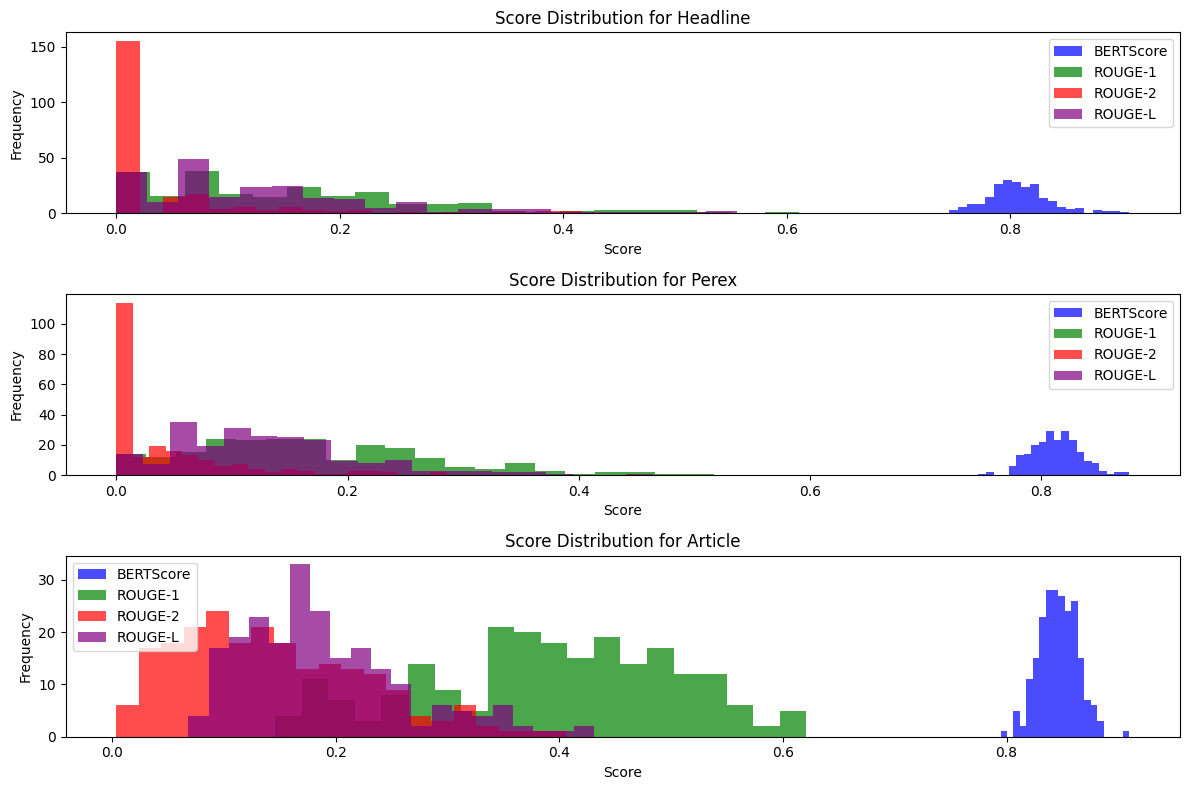

In [12]:
plt.figure(figsize=(12, 8))
for i, section in enumerate(sections):
    plt.subplot(3, 1, i+1)
    plt.hist(all_scores[section]['bert'], bins=20, alpha=0.7, label='BERTScore', color='blue')
    plt.hist(all_scores[section]['rouge1'], bins=20, alpha=0.7, label='ROUGE-1', color='green')
    plt.hist(all_scores[section]['rouge2'], bins=20, alpha=0.7, label='ROUGE-2', color='red')
    plt.hist(all_scores[section]['rougeL'], bins=20, alpha=0.7, label='ROUGE-L', color='purple')
    #plt.hist(all_scores[section]['llm_as_judge'], bins=20, alpha=0.7, label='LLM as judge', color='yellow')
    plt.title(f'Score Distribution for {section}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

# Boxplots of score types to showcase comparison of how well we did in different sections.

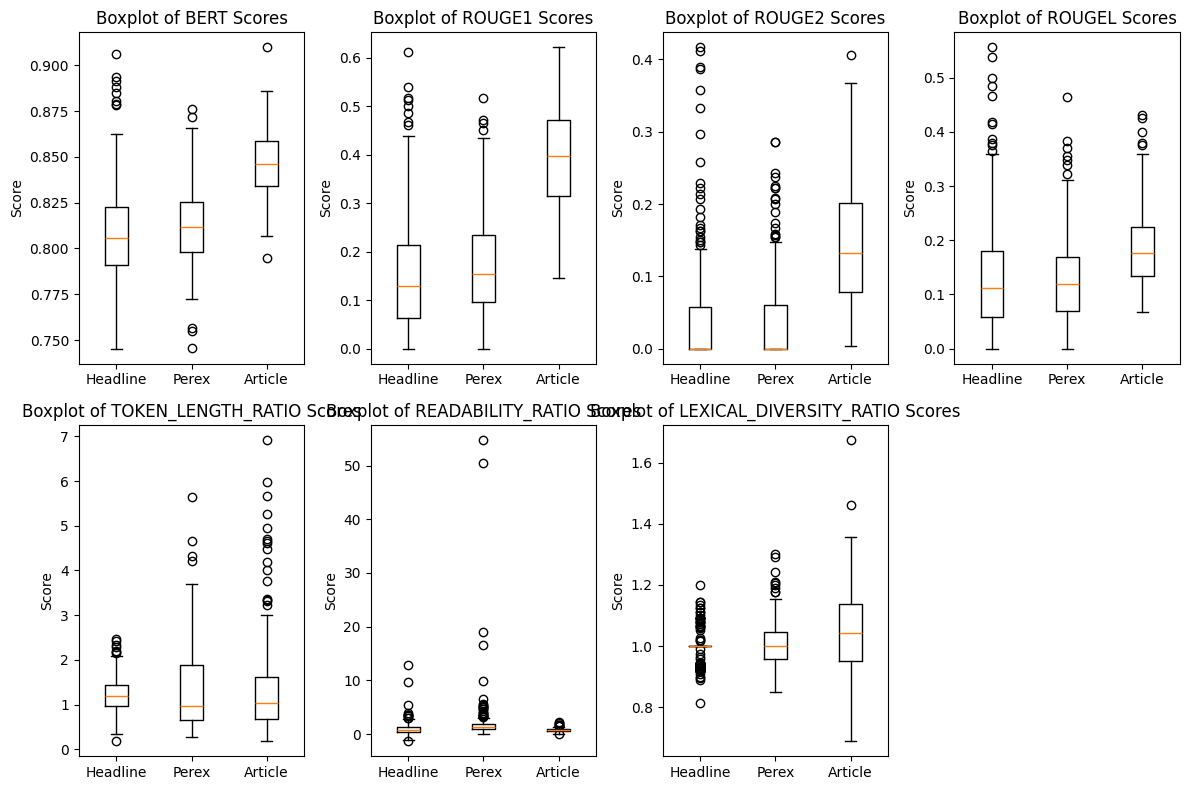

In [13]:
def plot_boxplots():
    plt.figure(figsize=(12, 8))
    for i, metric in enumerate(['bert', 'rouge1', 'rouge2', 'rougeL', 
                                #'llm_as_judge', 
                                'token_length_ratio', 'readability_ratio', 
                                'lexical_diversity_ratio']):
        plt.subplot(2, 4, i+1)
        plt.boxplot([all_scores[section][metric] for section in sections], tick_labels=sections)
        plt.title(f'Boxplot of {metric.upper()} Scores')
        plt.ylabel('Score')
    plt.tight_layout()
    plt.show()
plot_boxplots()


# Aggregated scores for each news site

In [14]:
# Min-Max Scale function for Token Length Ratio
def min_max_scale(values: List[float]) -> List[float]:
    min_val, max_val = np.min(values), np.max(values)
    return [(v - min_val) / (max_val - min_val) if max_val > min_val else 0 for v in values]

# Compute min-max scaled token length ratios for each section
token_length_ratios = {
    section: min_max_scale(all_scores[section]['token_length_ratio'])
    for section in ['Headline', 'Perex', 'Article']
}

## Similiarity scores heatmap

In [15]:
concat_articles = pd.concat([original_articles, generated_articles], ignore_index=True)

def compute_mean_scores(df, section, metrics):
    return {
        f"Mean_{metric}_{section}": np.mean([all_scores[section][metric][i] for i in df.index if i < len(all_scores[section][metric])])
        for metric in metrics
    }

# Define sections and their corresponding metrics
sections = ['Headline', 'Perex', 'Article']
metrics = ['bert', 'rouge1', 'rouge2', 'rougeL', #'llm_as_judge'
          ]

# Compute mean scores for each news site
news_site_results = (
    concat_articles.groupby('News Site')
    .apply(lambda df: pd.Series({
        **{metric: score for section in sections for metric, score in compute_mean_scores(df, section, metrics).items()}
    }))
    .reset_index()
)

# Display results
display(news_site_results)

C:\Users\tomca\AppData\Local\Temp\ipykernel_12776\1572529838.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({


,News Site,Mean_bert_Headline,Mean_rouge1_Headline,Mean_rouge2_Headline,Mean_rougeL_Headline,Mean_bert_Perex,Mean_rouge1_Perex,Mean_rouge2_Perex,Mean_rougeL_Perex,Mean_bert_Article,Mean_rouge1_Article,Mean_rouge2_Article,Mean_rougeL_Article
0,DennikN,0.809431,0.159816,0.044089,0.135479,0.827422,0.235006,0.073424,0.173091,0.839364,0.291566,0.082914,0.142857
1,Forbes,0.810951,0.159968,0.051022,0.136838,0.815695,0.198720,0.052851,0.149122,0.848884,0.405763,0.135892,0.181179
2,Pravda,0.806757,0.128132,0.026810,0.108820,0.814825,0.178354,0.044679,0.127410,0.843011,0.396715,0.149917,0.183123
3,SME,0.804164,0.121371,0.025678,0.105647,0.796880,0.094805,0.020032,0.081806,0.844997,0.409912,0.147613,0.192174
4,Teraz.sk,0.810840,0.187703,0.058157,0.173809,0.814496,0.180240,0.029126,0.140591,0.854148,0.449828,0.206510,0.234027
5,Trend,0.809549,0.145482,0.037162,0.125946,0.803053,0.125421,0.022060,0.104016,0.851446,0.425231,0.160644,0.216593


In [16]:
news_site_results

,News Site,Mean_bert_Headline,Mean_rouge1_Headline,Mean_rouge2_Headline,Mean_rougeL_Headline,Mean_bert_Perex,Mean_rouge1_Perex,Mean_rouge2_Perex,Mean_rougeL_Perex,Mean_bert_Article,Mean_rouge1_Article,Mean_rouge2_Article,Mean_rougeL_Article
0,DennikN,0.809431,0.159816,0.044089,0.135479,0.827422,0.235006,0.073424,0.173091,0.839364,0.291566,0.082914,0.142857
1,Forbes,0.810951,0.159968,0.051022,0.136838,0.815695,0.198720,0.052851,0.149122,0.848884,0.405763,0.135892,0.181179
2,Pravda,0.806757,0.128132,0.026810,0.108820,0.814825,0.178354,0.044679,0.127410,0.843011,0.396715,0.149917,0.183123
3,SME,0.804164,0.121371,0.025678,0.105647,0.796880,0.094805,0.020032,0.081806,0.844997,0.409912,0.147613,0.192174
4,Teraz.sk,0.810840,0.187703,0.058157,0.173809,0.814496,0.180240,0.029126,0.140591,0.854148,0.449828,0.206510,0.234027
5,Trend,0.809549,0.145482,0.037162,0.125946,0.803053,0.125421,0.022060,0.104016,0.851446,0.425231,0.160644,0.216593


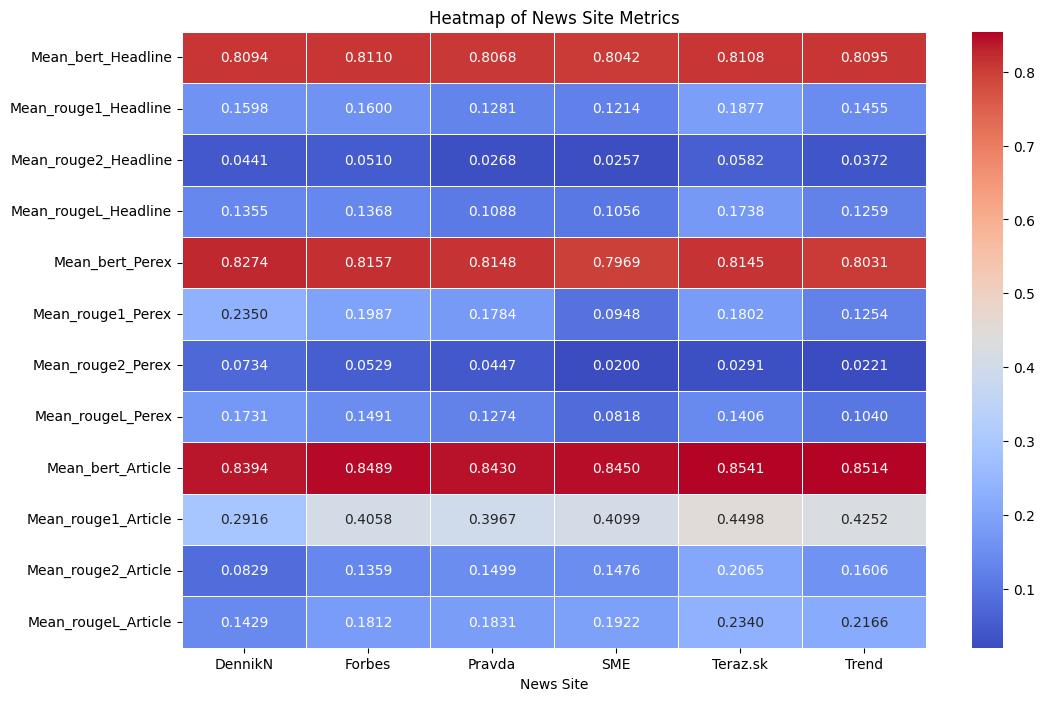

In [17]:
news_site_results_transposed = news_site_results.set_index('News Site').T

plt.figure(figsize=(12, 8))
sns.heatmap(news_site_results_transposed, annot=True, cmap='coolwarm', fmt='.4f', linewidths=0.5)
plt.title('Heatmap of News Site Metrics')
plt.show()

# Other metrics comparison Human vs AI

In [18]:
def create_ratio_metric_table(metric_column_name, metric):
    news_sites_ratio_metrics = concat_articles.groupby('News Site').apply(lambda df: pd.Series({
    f'Mean_{metric_column_name}_Headline': np.mean([all_scores['Headline'][metric][i] for i in df.index if i < len(all_scores['Headline'][metric])]),
    f'Mean_{metric_column_name}_Perex': np.mean([all_scores['Perex'][metric][i] for i in df.index if i < len(all_scores['Perex'][metric])]),
    f'Mean_{metric_column_name}_Article': np.mean([all_scores['Article'][metric][i] for i in df.index if i < len(all_scores['Article'][metric])]),
    })).reset_index()
    return news_sites_ratio_metrics

In [19]:
def create_heatmap(table, metric):
    news_site_token_lengths_transposed = table.set_index('News Site').T

    plt.figure(figsize=(12, 8))
    sns.heatmap(news_site_token_lengths_transposed, annot=True, cmap='coolwarm', fmt='.4f', linewidths=0.5)
    plt.title(f'Heatmap of News Site {metric}')
    plt.show()

In [20]:
def create_comparison_table(metric_column_name1, metric1, metric_column_name2, metric2):
    news_sites_comparison_metrics = concat_articles.groupby('News Site').apply(lambda df: pd.Series({
    f'Mean_{metric_column_name1}_Headline': np.mean([all_scores['Headline'][metric1][i] for i in df.index if i < len(all_scores['Headline'][metric1])]),
    f'Mean_{metric_column_name2}_Headline': np.mean([all_scores['Headline'][metric2][i] for i in df.index if i < len(all_scores['Headline'][metric2])]),
    f'Mean_{metric_column_name1}_Perex': np.mean([all_scores['Perex'][metric1][i] for i in df.index if i < len(all_scores['Perex'][metric1])]),
    f'Mean_{metric_column_name2}_Perex': np.mean([all_scores['Perex'][metric2][i] for i in df.index if i < len(all_scores['Perex'][metric2])]),
    f'Mean_{metric_column_name1}_Article': np.mean([all_scores['Article'][metric1][i] for i in df.index if i < len(all_scores['Article'][metric1])]),
    f'Mean_{metric_column_name2}_Article': np.mean([all_scores['Article'][metric2][i] for i in df.index if i < len(all_scores['Article'][metric2])]),
    })).reset_index()
    return news_sites_comparison_metrics

In [21]:
def create_facetgrid_comparison(table, metric_column_name1, metric1, metric_column_name2, metric2):
    # Pivot longer
    melted_data = pd.melt(table, 
                         id_vars=["News Site"], 
                         value_vars=[
                             f'Mean_{metric_column_name1}_Headline', 
                             f'Mean_{metric_column_name2}_Headline',
                             f'Mean_{metric_column_name1}_Perex', 
                             f'Mean_{metric_column_name2}_Perex',
                             f'Mean_{metric_column_name1}_Article', 
                             f'Mean_{metric_column_name2}_Article'
                         ],
                         var_name="Metric",
                         value_name="Score")
    
    # Extractin section and human or ai from metric attribute (for example Mean_AI_Readability_Headline)
    melted_data["Section"] = melted_data["Metric"].str.extract(r"_(Headline|Perex|Article)")[0]
    melted_data["Human/AI"] = melted_data["Metric"].apply(lambda x: "AI" if metric_column_name2 in x else "Human")

    # FacetGrid containing each section
    g = sns.FacetGrid(melted_data, col="Section", col_wrap=3, height=5, sharey=False)
    
    # Barplots for each section
    g.map(sns.barplot, "News Site", "Score", "Human/AI", palette="Set2", ci=None, dodge=True)
    
    g.set_titles("{col_name} Comparison (Human vs AI)")
    g.set_axis_labels("News Site", "Score")
    
    g.tight_layout()
    plt.show()


## Token length evaluation

In [22]:
token_table = create_ratio_metric_table("Token_Length_Ratio", "token_length_ratio")
token_table

C:\Users\tomca\AppData\Local\Temp\ipykernel_12776\3789373024.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  news_sites_ratio_metrics = concat_articles.groupby('News Site').apply(lambda df: pd.Series({


,News Site,Mean_Token_Length_Ratio_Headline,Mean_Token_Length_Ratio_Perex,Mean_Token_Length_Ratio_Article
0,DennikN,1.138301,0.692358,2.628962
1,Forbes,1.068752,0.837092,1.123514
2,Pravda,1.018603,0.515059,0.787881
3,SME,1.426356,2.786781,0.838818
4,Teraz.sk,1.444636,1.151221,1.256941
5,Trend,1.259057,1.999200,1.106097


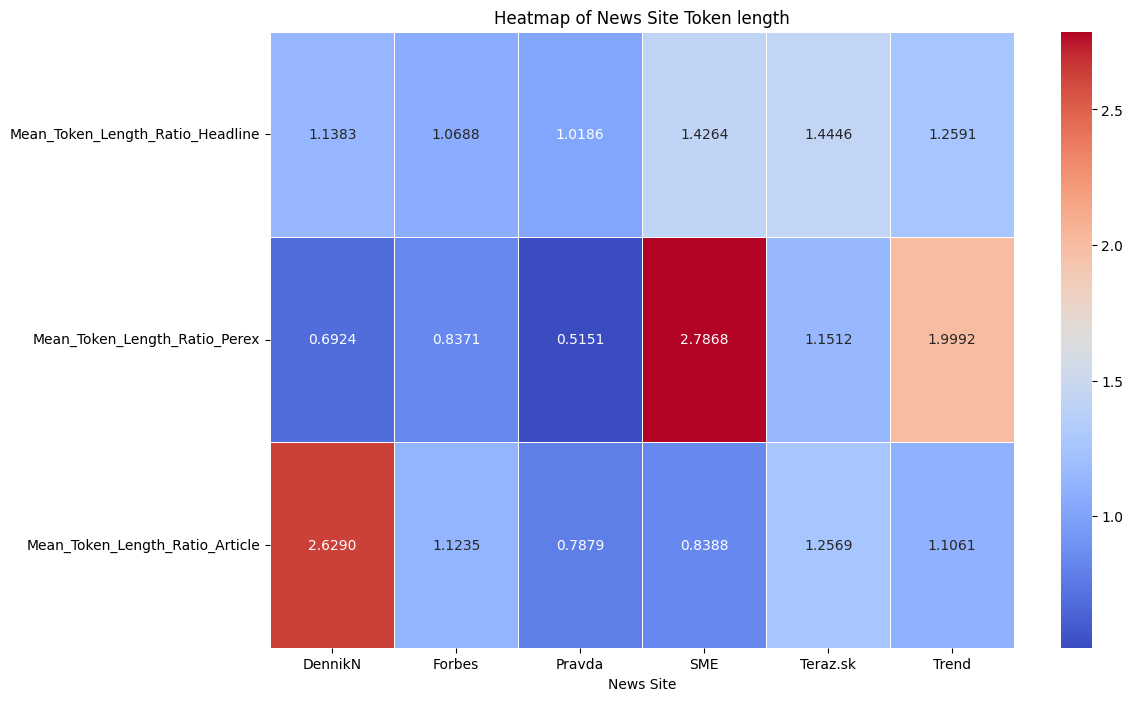

In [23]:
create_heatmap(token_table, "Token length")

# Readability evaluation

In [24]:
readability_comparison_table = create_comparison_table("Human_Readability", "human_readability", "AI_Readability","ai_readability")
readability_comparison_table

C:\Users\tomca\AppData\Local\Temp\ipykernel_12776\726637064.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  news_sites_comparison_metrics = concat_articles.groupby('News Site').apply(lambda df: pd.Series({


,News Site,Mean_Human_Readability_Headline,Mean_AI_Readability_Headline,Mean_Human_Readability_Perex,Mean_AI_Readability_Perex,Mean_Human_Readability_Article,Mean_AI_Readability_Article
0,DennikN,41.142855,37.783352,50.789714,70.803174,43.692686,32.774981
1,Forbes,51.828788,32.589034,44.635163,66.857454,36.150845,26.237601
2,Pravda,46.985949,33.579480,62.371048,67.427177,45.880889,30.985700
3,SME,31.675863,37.787225,39.035397,70.059417,45.247827,29.912022
4,Teraz.sk,58.303075,39.777327,56.319209,64.311443,54.916677,33.175632
5,Trend,28.135949,34.506744,29.848833,72.103963,43.157520,34.098613


C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisg

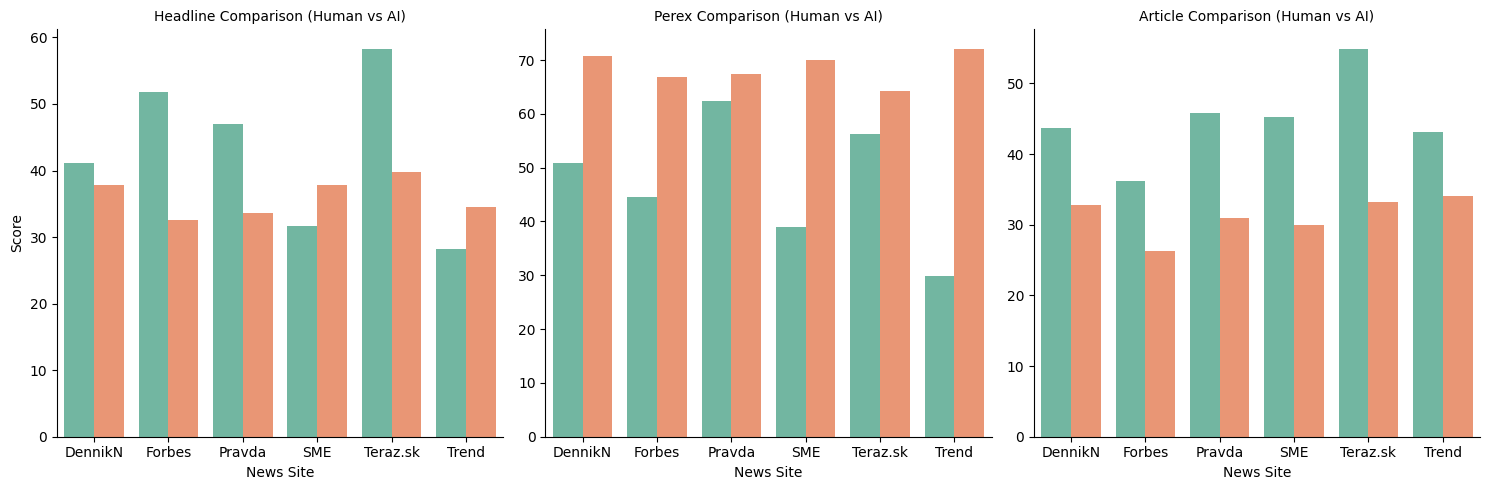

In [25]:
create_facetgrid_comparison(readability_comparison_table, "Human_Readability", "human_readability", "AI_Readability", "ai_readability")

In [26]:
readability_table = create_ratio_metric_table("Readability_Ratio", "readability_ratio")
readability_table

C:\Users\tomca\AppData\Local\Temp\ipykernel_12776\3789373024.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  news_sites_ratio_metrics = concat_articles.groupby('News Site').apply(lambda df: pd.Series({


,News Site,Mean_Readability_Ratio_Headline,Mean_Readability_Ratio_Perex,Mean_Readability_Ratio_Article
0,DennikN,0.970619,1.510817,0.792062
1,Forbes,0.960610,1.895452,0.788464
2,Pravda,1.088405,1.138436,0.706755
3,SME,1.088998,4.414199,0.679763
4,Teraz.sk,0.778288,1.324737,0.636303
5,Trend,1.246157,2.571715,0.813844


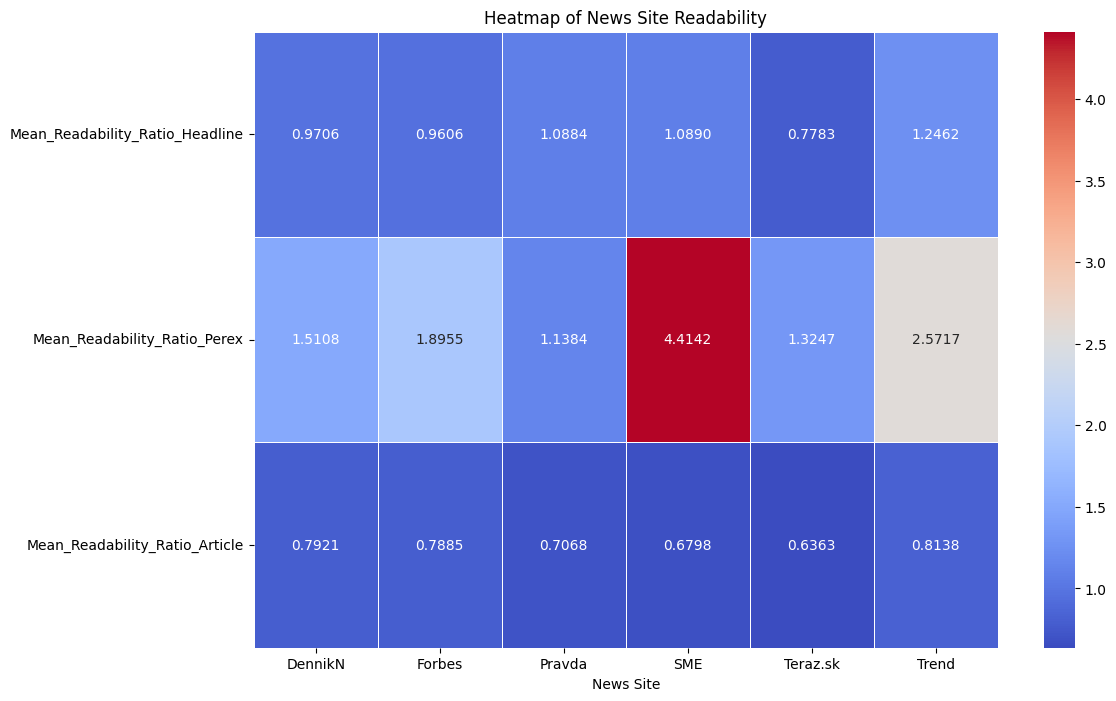

In [27]:
create_heatmap(readability_table, "Readability")

# Lexical diversity evaluation

In [28]:
lexical_diversity_comparison_table = create_comparison_table("Human_Lexical_Diversity", "human_lexical_diversity", "AI_Lexical_Diversity","ai_lexical_diversity")
lexical_diversity_comparison_table

C:\Users\tomca\AppData\Local\Temp\ipykernel_12776\726637064.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  news_sites_comparison_metrics = concat_articles.groupby('News Site').apply(lambda df: pd.Series({


,News Site,Mean_Human_Lexical_Diversity_Headline,Mean_AI_Lexical_Diversity_Headline,Mean_Human_Lexical_Diversity_Perex,Mean_AI_Lexical_Diversity_Perex,Mean_Human_Lexical_Diversity_Article,Mean_AI_Lexical_Diversity_Article
0,DennikN,0.982782,0.983342,0.947703,0.965829,0.817746,0.715524
1,Forbes,0.976752,0.979403,0.945133,0.970859,0.692322,0.708883
2,Pravda,0.987074,0.981839,0.890041,0.976272,0.646571,0.727112
3,SME,0.985113,0.978000,1.000000,0.959252,0.656855,0.720148
4,Teraz.sk,0.988552,0.987500,0.971161,0.978077,0.678769,0.731296
5,Trend,0.995338,0.981561,0.992208,0.973853,0.672898,0.721240


C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisg

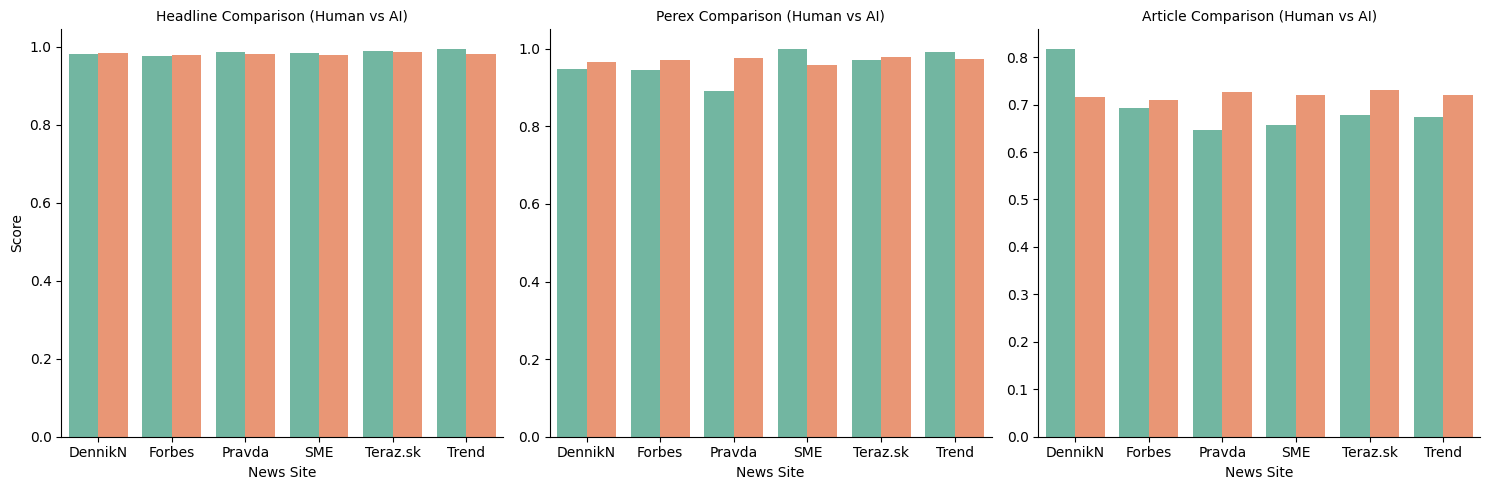

In [29]:
create_facetgrid_comparison(lexical_diversity_comparison_table, "Human_Lexical_Diversity", "human_lexical_diversity", "AI_Lexical_Diversity","ai_lexical_diversity")

In [30]:
lexical_diversity_table = create_ratio_metric_table("Lexical_Diversity_Ratio", "lexical_diversity_ratio")
lexical_diversity_table

C:\Users\tomca\AppData\Local\Temp\ipykernel_12776\3789373024.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  news_sites_ratio_metrics = concat_articles.groupby('News Site').apply(lambda df: pd.Series({


,News Site,Mean_Lexical_Diversity_Ratio_Headline,Mean_Lexical_Diversity_Ratio_Perex,Mean_Lexical_Diversity_Ratio_Article
0,DennikN,1.001913,1.022069,0.885296
1,Forbes,1.004814,1.029668,1.032425
2,Pravda,0.995715,1.100889,1.131320
3,SME,0.993931,0.959252,1.104752
4,Teraz.sk,1.000165,1.010262,1.084782
5,Trend,0.986492,0.982081,1.077988


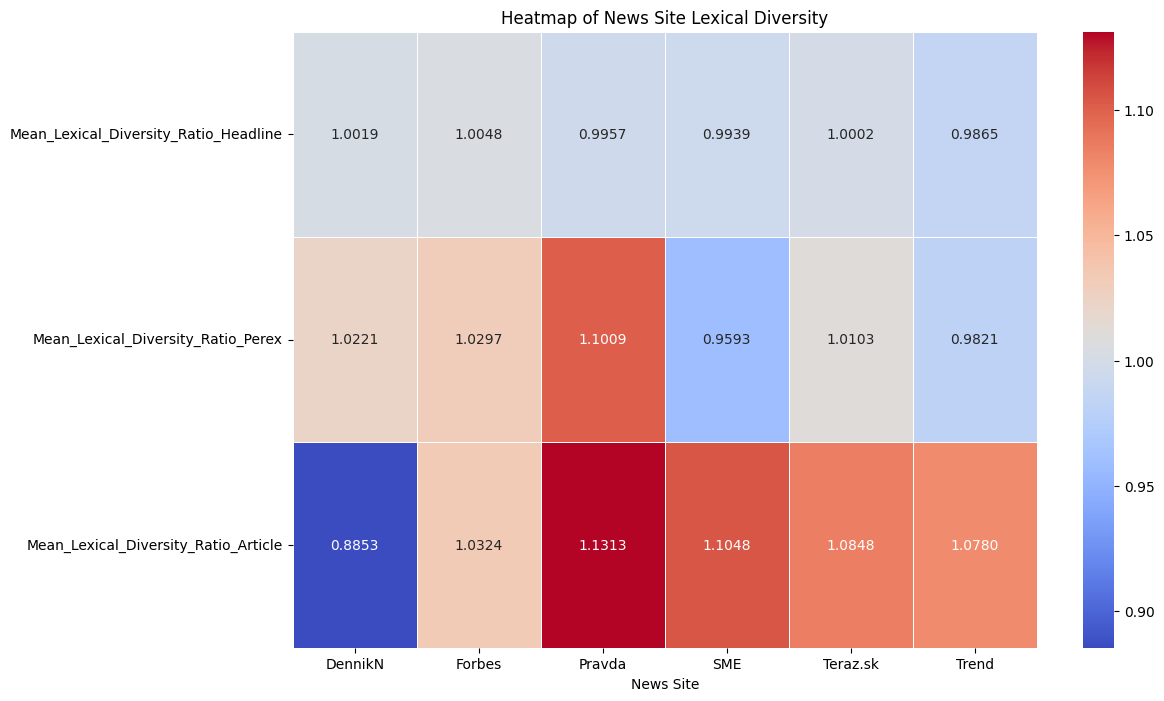

In [31]:
create_heatmap(lexical_diversity_table, "Lexical Diversity")

# Grammar errors evaluation

In [32]:
grammar_errors_comparison_table = create_comparison_table("Human_Grammar_Errors", "human_grammar_errors", "AI_Grammar_Errors","ai_grammar_errors")
grammar_errors_comparison_table

C:\Users\tomca\AppData\Local\Temp\ipykernel_12776\726637064.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  news_sites_comparison_metrics = concat_articles.groupby('News Site').apply(lambda df: pd.Series({


,News Site,Mean_Human_Grammar_Errors_Headline,Mean_AI_Grammar_Errors_Headline,Mean_Human_Grammar_Errors_Perex,Mean_AI_Grammar_Errors_Perex,Mean_Human_Grammar_Errors_Article,Mean_AI_Grammar_Errors_Article
0,DennikN,0.224490,0.530612,0.571429,0.163265,3.693878,2.081633
1,Forbes,0.192308,0.615385,0.346154,0.153846,4.423077,1.538462
2,Pravda,0.117647,0.882353,0.764706,0.235294,9.294118,1.558824
3,SME,0.048780,0.951220,0.121951,0.365854,7.390244,1.634146
4,Teraz.sk,0.090909,0.272727,0.484848,0.121212,4.848485,1.727273
5,Trend,0.128205,0.692308,0.128205,0.282051,4.538462,2.205128


C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\tomca\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisg

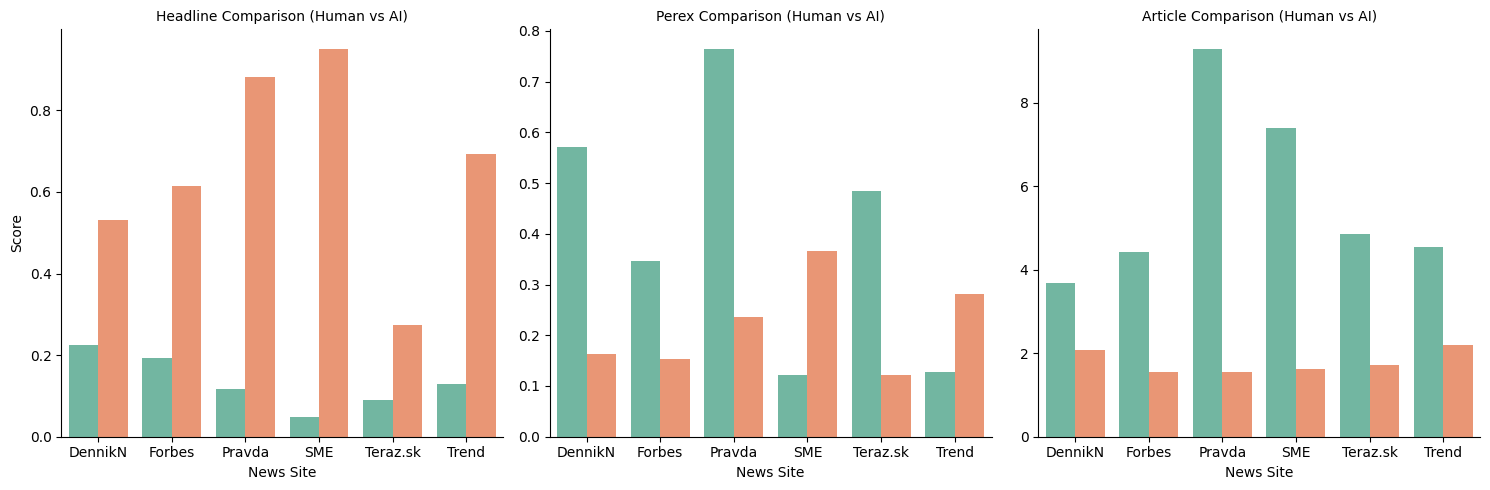

In [33]:
create_facetgrid_comparison(grammar_errors_comparison_table, "Human_Grammar_Errors", "human_grammar_errors", "AI_Grammar_Errors","ai_grammar_errors")

In [34]:
grammar_error_table = create_ratio_metric_table("Grammar_Error_Ratio", "grammar_errors_ratio")
grammar_error_table

C:\Users\tomca\AppData\Local\Temp\ipykernel_12776\3789373024.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  news_sites_ratio_metrics = concat_articles.groupby('News Site').apply(lambda df: pd.Series({


,News Site,Mean_Grammar_Error_Ratio_Headline,Mean_Grammar_Error_Ratio_Perex,Mean_Grammar_Error_Ratio_Article
0,DennikN,inf,inf,inf
1,Forbes,inf,inf,inf
2,Pravda,inf,inf,inf
3,SME,inf,inf,inf
4,Teraz.sk,inf,inf,inf
5,Trend,inf,inf,inf


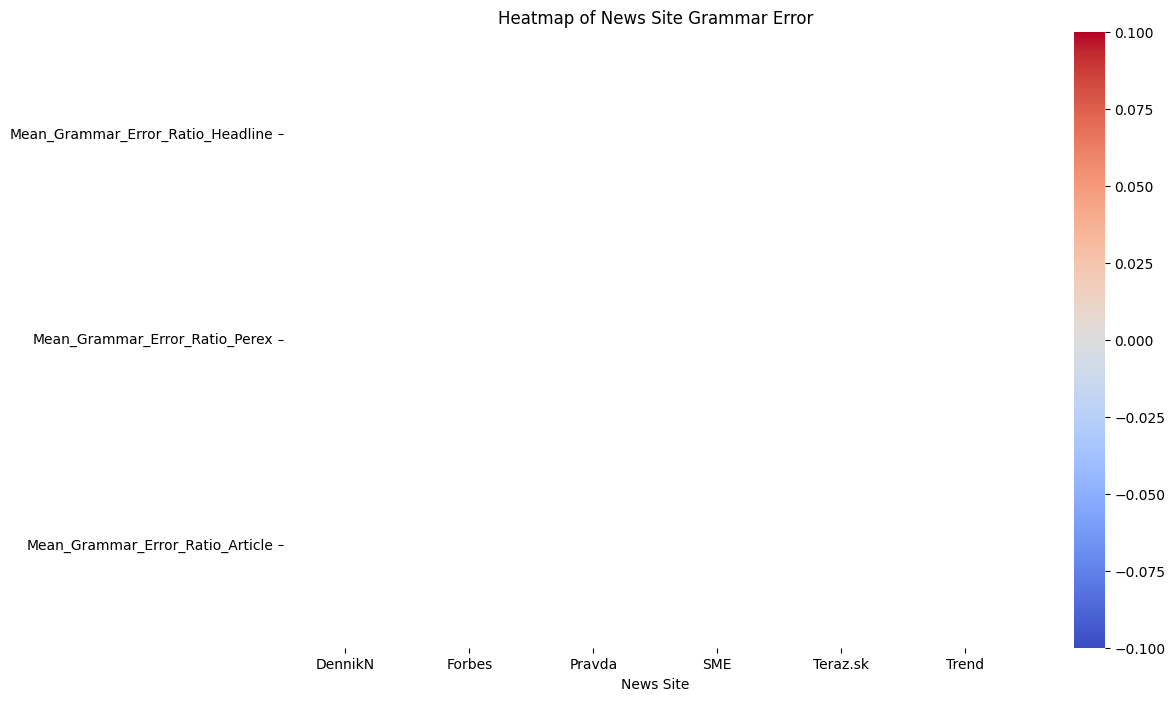

In [35]:
create_heatmap(grammar_error_table, "Grammar Error")